In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from feature_extraction import person_finder, org_finder, state_agg, imputed_600, method_flagger

In [5]:
polls = pd.read_csv('../data/raw-polls.csv')
pollster_ratings = pd.read_csv('../data/pollster-ratings.csv')

In [6]:
polls.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10776 entries, 0 to 10775
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   poll_id             10776 non-null  int64  
 1   question_id         10776 non-null  int64  
 2   race_id             10776 non-null  int64  
 3   year                10776 non-null  int64  
 4   race                10776 non-null  object 
 5   location            10776 non-null  object 
 6   type_simple         10776 non-null  object 
 7   type_detail         10776 non-null  object 
 8   pollster            10776 non-null  object 
 9   pollster_rating_id  10776 non-null  int64  
 10  methodology         10776 non-null  object 
 11  partisan            819 non-null    object 
 12  polldate            10776 non-null  object 
 13  samplesize          10776 non-null  float64
 14  cand1_name          10776 non-null  object 
 15  cand1_id            10776 non-null  int64  
 16  cand

In [16]:
polls.loc[:, polls.isna().sum() > 0].columns # Partisan, cand3_pct, and comment
                                             # having NAs is reasonable but bias
                                             # should not have any. We will fix this
                                             # now so our plots are accurate.

Index(['partisan', 'cand3_pct', 'bias', 'comment'], dtype='object')

In [17]:
polls['calc_bias'] = polls['margin_poll'] - polls['margin_actual'] # same formula as data dictionary
np.mean(polls['error'] - np.abs(polls['calc_bias'])) # about as accurate as we can get

-9.27550055675687e-07

In [7]:
polls.head()

,poll_id,question_id,race_id,year,race,location,type_simple,type_detail,pollster,pollster_rating_id,...,margin_poll,electiondate,cand1_actual,cand2_actual,margin_actual,error,bias,rightcall,advancedplusminus,comment
0,26013,87909,1455,1998,1998_Gov-G_NY,NY,Gov-G,Gov-G,Blum & Weprin Associates,32,...,-31.0,11/3/1998,33.16,54.32,-21.15,9.85,-9.85,1.0,1.461561,for New York Daily News | WABC-TV (New York)
1,26255,87926,1456,1998,1998_Gov-G_OH,OH,Gov-G,Gov-G,University of Cincinnati (Ohio Poll),346,...,-15.0,11/3/1998,44.69,50.05,-5.36,9.64,-9.64,1.0,4.285789,NaN
2,26026,31266,1736,1998,1998_Sen-G_NV,NV,Sen-G,Sen-G,FM3 Research,91,...,5.0,11/3/1998,47.86,47.77,0.09,4.91,4.91,1.0,-1.023784,for unspecified Democratic sponsor
3,26013,31253,1738,1998,1998_Sen-G_NY,NY,Sen-G,Sen-G,Blum & Weprin Associates,32,...,-8.0,11/3/1998,54.62,44.08,10.54,18.54,-18.54,0.0,10.064104,for New York Daily News | WABC-TV (New York)
4,63632,117103,1738,1998,1998_Sen-G_NY,NY,Sen-G,Sen-G,Garin-Hart-Yang Research Group,113,...,4.0,11/3/1998,54.62,44.08,10.54,6.54,-6.54,1.0,-1.972391,for Charles E. Schumer


In [8]:
pollster_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 21 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Rank                                          517 non-null    int64  
 1   Pollster                                      517 non-null    object 
 2   Pollster Rating ID                            517 non-null    int64  
 3   Polls Analyzed                                517 non-null    int64  
 4   AAPOR/Roper                                   517 non-null    object 
 5   Banned by 538                                 517 non-null    object 
 6   Predictive Plus-Minus                         517 non-null    float64
 7   538 Grade                                     517 non-null    object 
 8   Mean-Reverted Bias                            473 non-null    float64
 9   Races Called Correctly                        517 non-null    flo

In [9]:
pollster_ratings.head()

,Rank,Pollster,Pollster Rating ID,Polls Analyzed,AAPOR/Roper,Banned by 538,Predictive Plus-Minus,538 Grade,Mean-Reverted Bias,Races Called Correctly,...,Simple Average Error,Simple Expected Error,Simple Plus-Minus,Advanced Plus-Minus,Mean-Reverted Advanced Plus-Minus,# of Polls for Bias Analysis,Bias,House Effect,Average Distance from Polling Average (ADPA),Herding Penalty
0,1,The New York Times/Siena College,448,95,yes,no,-1.192860,A+,1.006012,0.747368,...,4.043250,5.364792,-1.318429,-1.625523,-1.318372,94,1.243260,0.700506,3.575558,0.261188
1,2,Selzer & Co.,304,53,yes,no,-1.175911,A+,0.161120,0.811321,...,4.916848,5.959235,-1.039274,-1.622671,-1.000844,35,0.297645,-0.343495,5.288403,0.000000
2,3,Research & Polling Inc.,280,44,no,no,-0.965392,A+,-0.582568,0.886364,...,4.177286,5.548050,-1.367651,-1.938115,-1.183301,43,-0.956078,0.632896,4.642076,0.286276
3,4,SurveyUSA,325,856,no,no,-0.917320,A+,0.003251,0.891355,...,4.681671,5.642531,-0.957747,-1.094410,-1.043528,697,0.003447,-0.526230,4.969035,0.126963
4,5,Marquette University Law School,195,15,yes,no,-0.908215,A/B,0.237527,0.800000,...,2.846556,5.938505,-3.088836,-3.191347,-1.208475,11,0.751227,-0.199840,4.201278,0.257600


In [18]:
pollster_ratings.loc[:, pollster_ratings.isna().sum() > 0].columns

Index(['Mean-Reverted Bias', 'Bias', 'House Effect',
       'Average Distance from Polling Average (ADPA)'],
      dtype='object')

In [19]:
pollster_ratings[pollster_ratings.loc[:, pollster_ratings.isna().sum() > 0].columns].isna().sum()

Mean-Reverted Bias                               44
Bias                                             44
House Effect                                     62
Average Distance from Polling Average (ADPA)    108
dtype: int64

Our data here is incomplete, for the bias variables those are due to not enough polls to analyze bias on 538's part. House Effect requires a comparison to other partisan polls in the same race so these are likely NA's for a valid reason. ADPA however is a bit troubling so let's analyze that more closely.

In [41]:
pollster_ratings[pollster_ratings['Average Distance from Polling Average (ADPA)'].isna()]['Polls Analyzed'].describe()

count    108.000000
mean       2.277778
std        2.629215
min        1.000000
25%        1.000000
50%        1.500000
75%        2.000000
max       18.000000
Name: Polls Analyzed, dtype: float64

538 states their process for calculating ADPA is: we start by calculating how much the pollster’s average poll differs from the average of previous polls of that race — specifically, polls whose median field date was at least three days earlier and it is weighted based on the square root of the number of other polls in the field for each race.([source](https://fivethirtyeight.com/methodology/how-our-pollster-ratings-work/)) These NA values should be caused by races where there weren't enough other polls in the field, likely 0 previous polls. We will proceed as is because we do not intend to use any of these variables.

In [50]:
# Merging our dataframes for ease of use
df = pd.merge(left = polls, right = pollster_ratings, 
              how = 'left', 
              left_on = 'pollster_rating_id', right_on = 'Pollster Rating ID'
              )

In [43]:
df.head()

,poll_id,question_id,race_id,year,race,location,type_simple,type_detail,pollster,pollster_rating_id,...,Simple Average Error,Simple Expected Error,Simple Plus-Minus,Advanced Plus-Minus,Mean-Reverted Advanced Plus-Minus,# of Polls for Bias Analysis,Bias,House Effect,Average Distance from Polling Average (ADPA),Herding Penalty
0,26013,87909,1455,1998,1998_Gov-G_NY,NY,Gov-G,Gov-G,Blum & Weprin Associates,32,...,4.740100,5.234178,-0.490965,-2.175389,-0.421866,17.0,-3.425434,0.567141,4.544692,0.050743
1,26255,87926,1456,1998,1998_Gov-G_OH,OH,Gov-G,Gov-G,University of Cincinnati (Ohio Poll),346,...,4.199093,5.689016,-1.486810,-0.853513,-0.368557,30.0,-3.205671,-2.558033,3.438590,0.433143
2,26026,31266,1736,1998,1998_Sen-G_NV,NV,Sen-G,Sen-G,FM3 Research,91,...,8.428978,5.610426,2.821665,3.913602,1.008798,11.0,7.962182,6.893962,6.106365,0.000000
3,26013,31253,1738,1998,1998_Sen-G_NY,NY,Sen-G,Sen-G,Blum & Weprin Associates,32,...,4.740100,5.234178,-0.490965,-2.175389,-0.421866,17.0,-3.425434,0.567141,4.544692,0.050743
4,63632,117103,1738,1998,1998_Sen-G_NY,NY,Sen-G,Sen-G,Garin-Hart-Yang Research Group,113,...,5.391699,5.595187,-0.200375,-0.332816,-0.175144,33.0,3.537298,4.275848,5.201474,0.036066


First, let's extract some features from the comment and methodology columns. Additionally, we will be cleaning the state column slightly to account for Maine and Nevada separate designations due to their unique presidential voting situation ([source](https://www.smithsonianmag.com/smart-news/why-do-maine-and-nebraska-split-their-electoral-votes-180976219/)). 

In [51]:
df['org'] = df['comment'].apply(
    lambda x: org_finder(x) if x is not np.nan else 0
    )

df['person'] = df['comment'].apply(
    lambda x: person_finder(x) if x is not np.nan else 0
    )

df['anon'] = df['comment'].str.contains('unspecified').apply(
    lambda x: 1 if x == True else 0
    )

df['registered_voters'] = df['comment'].str.contains(
    r"registered voters|'voters'"
    ).apply(
        lambda x: 1 if x == True else 0
        ) # we are counting 'voters' as registered voters and not likely voters

df['averaged'] = df['comment'].str.contains('average').apply(
    lambda x: 1 if x == True else 0
    )

df['partisan'] = df['partisan'].map(
    {
        'D' : 'D',
        'R' : 'R',
        np.nan : 'NPL',
        'IND' : 'NPL' # There's only one case of this 
    }
)

df['imputed_600'] = imputed_600(df)

df['days_bt_polldate_election'] = (pd.to_datetime(df['electiondate']) - pd.to_datetime(df['polldate'])).dt.days

df = pd.merge(df, 
              pd.DataFrame(method_flagger(df['methodology'])), 
              left_index=True, 
              right_index=True)

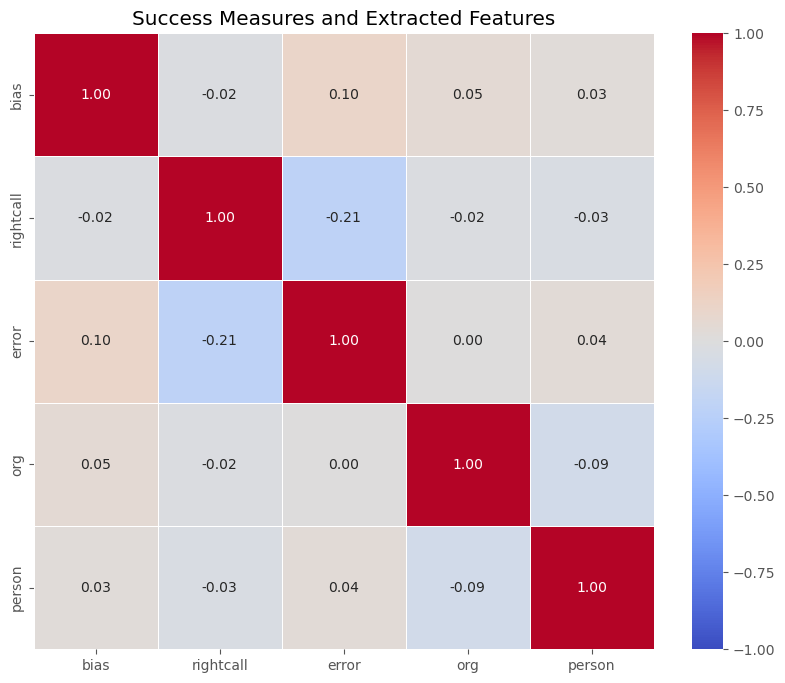

In [69]:
# Heat map exploring if being a ORG v Person is correlated with features like "rightcall" or "bias" - no strong correlations here 
heatmap_data = df[['bias', 'rightcall', 'error', 'org', 'person']]
correlation_matrix = heatmap_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, 
            cmap='coolwarm', fmt='.2f', 
            linewidths=.5, vmax = 1, vmin = -1)
plt.title('Success Measures and Extracted Features');

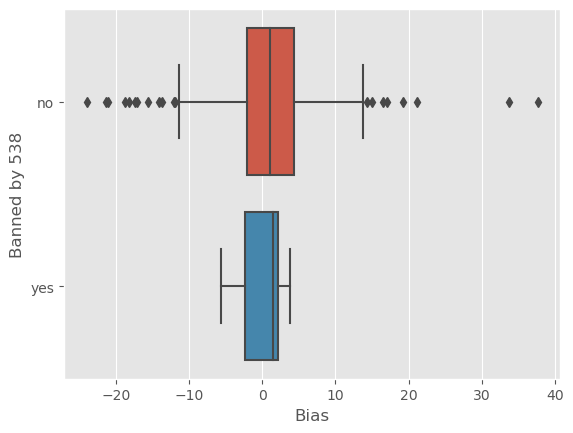

In [88]:
sns.boxplot(pollster_ratings, x = 'Bias', y = 'Banned by 538');

In [90]:
pollster_ratings['Banned by 538'].value_counts() # barely any are banned

Banned by 538
no     506
yes     11
Name: count, dtype: int64

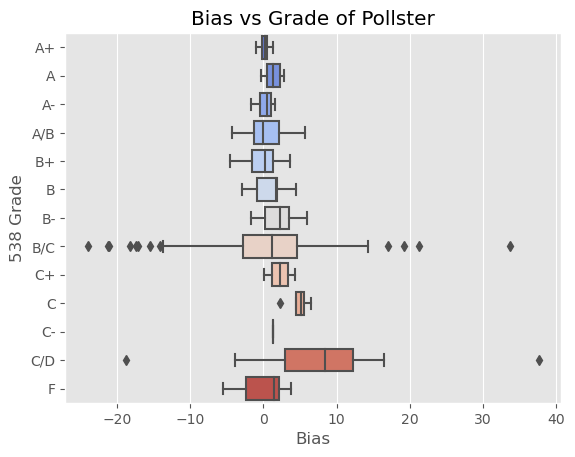

In [87]:
sns.boxplot(pollster_ratings, 
            x = 'Bias', 
            y = '538 Grade', 
            palette = 'coolwarm', 
            order = ['A+', 'A', 'A-', 'A/B', 'B+', 'B', 'B-', 'B/C', 'C+', 'C', 'C-', 'C/D', 'F'],
        )

plt.title('Bias vs Grade of Pollster');

In [92]:
pollster_ratings['538 Grade'].value_counts()[sorted(pollster_ratings['538 Grade'].unique())] 
# Vast majority are graded B/C

538 Grade
A        8
A+       4
A-       9
A/B     47
B       10
B+      11
B-       9
B/C    382
C        4
C+       2
C-       1
C/D     19
F       11
Name: count, dtype: int64

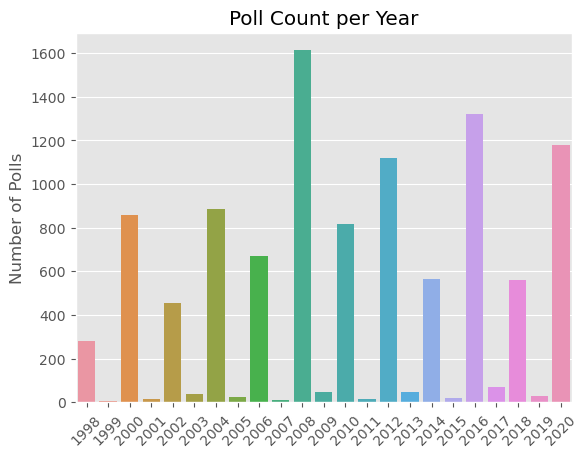

In [85]:
polls_vs_year = df.groupby('year')['Bias'].count()
sns.barplot(
    x = polls_vs_year.index,
    y = polls_vs_year.values
)
plt.xticks(rotation = 45)
plt.xlabel('')
plt.ylabel('Number of Polls')
plt.title('Poll Count per Year');